We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Data fields description:
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date - date in format dd/mm/yyyy
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from calendar import monthrange
from pandas.core import datetools

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train_df = pd.read_csv('./data/sales_train.csv')
print('Training rows:  {:,}'.format(len(train_df)))

train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')

# Let's break up the date field into constituent pieces.
train_df['date (year)'] = train_df['date'].dt.year
train_df['date (month)'] = train_df['date'].dt.month
train_df['date (day)'] = train_df['date'].dt.day
train_df['date (day of week)'] = train_df['date'].dt.dayofweek
train_df['date (day of year)'] = train_df['date'].dt.dayofyear
train_df['date (week of year)'] = train_df['date'].dt.weekofyear
train_df['date (days in month)'] = train_df['date'].apply(lambda x: monthrange(x.year, x.month)[1])

train_df.head(2).transpose()

Training rows:  2,935,849


,0,1
date,2013-01-02 00:00:00,2013-01-03 00:00:00
date_block_num,0,0
shop_id,59,25
item_id,22154,2552
item_price,999,899
item_cnt_day,1,1
date (year),2013,2013
date (month),1,1
date (day),2,3
date (day of week),2,3


In [3]:
shops_df = pd.read_csv('./data/shops.csv')
print('Shop rows:  {:,}'.format(len(shops_df)))

shops_df['shop_id'] = shops_df['shop_id'].astype(int)

shops_df.head(3)

Shop rows:  60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [4]:
items_df = pd.read_csv('./data/items.csv')
print('Item rows:  {:,}'.format(len(items_df)))

items_df['item_id'] = items_df['item_id'].astype(int)
items_df['item_category_id'] = items_df['item_category_id'].astype(int)

items_df.head(3)

Item rows:  22,170


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [5]:
item_cats_df = pd.read_csv('./data/item_categories.csv')
print('Item category rows:  {:,}'.format(len(item_cats_df)))

item_cats_df['item_category_id'] = item_cats_df['item_category_id'].astype(int)

item_cats_df.head(3)

Item category rows:  84


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


Let's plot the sales for some random shops.

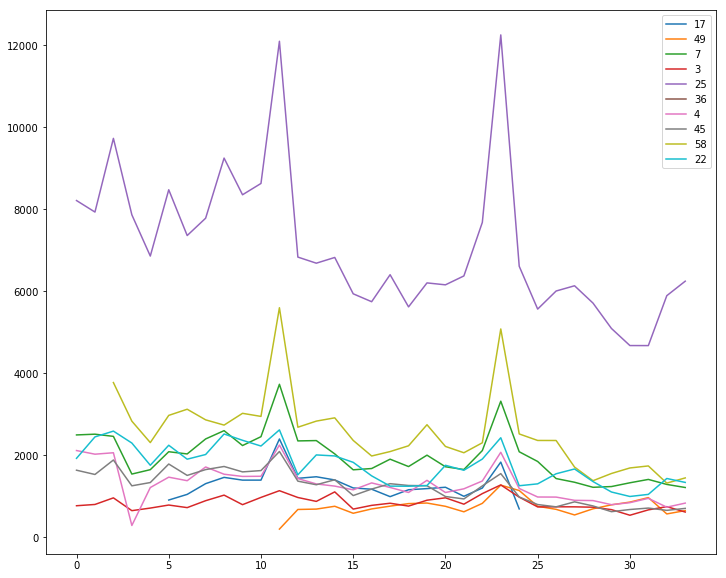

In [6]:
plt.figure(figsize=(12,10))

grouped_df = train_df.groupby(['shop_id', 'date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()

shops_sample = shops_df['shop_id'].sample(10)

for shop in shops_sample:
    subset_df = grouped_df[
        grouped_df['shop_id'] == shop
    ]
    
    plt.plot(subset_df['date_block_num'], subset_df['item_cnt_day'], label=shop)
    

plt.legend(loc='best')

A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

In [7]:
grouped_df = train_df.groupby(['date (year)', 'date (month)', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum'}).reset_index()
grouped_df.head(5)

,date (year),date (month),shop_id,item_id,item_cnt_day
0,2013,1,0,32,6.0
1,2013,1,0,33,3.0
2,2013,1,0,35,1.0
3,2013,1,0,43,1.0
4,2013,1,0,51,2.0


In [8]:
grouped_df.isnull().sum()

date (year)     0
date (month)    0
shop_id         0
item_id         0
item_cnt_day    0
dtype: int64

In [9]:
results_df = grouped_df[
    (grouped_df['date (year)'] == 2015) & (grouped_df['date (month)'] == 10)
]
results_df = results_df.groupby(['shop_id', 'item_id']).agg({'item_cnt_day': 'sum'}).reset_index()
results_df.columns = ['shop_id', 'item_id', 'item_cnt_month']
results_df.head(5)

,shop_id,item_id,item_cnt_month
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0


In [10]:
results_df['item_cnt_month'].describe()

count    31531.000000
mean         2.253528
std         14.533295
min         -1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2253.000000
Name: item_cnt_month, dtype: float64

In [11]:
results_df['item_cnt_month'] = np.clip(results_df['item_cnt_month'], 0, 20)

results_df['item_cnt_month'].describe()

count    31531.000000
mean         1.953094
std          2.537943
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         20.000000
Name: item_cnt_month, dtype: float64

In [12]:
test_df = pd.read_csv('./data/test.csv')
print('Testing rows:  {:,}'.format(len(test_df)))

test_df.head(5)

Testing rows:  214,200


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [13]:
submission_df = test_df.merge(results_df, on=['shop_id', 'item_id'], how='left')
print(len(submission_df))

submission_df['item_cnt_month'] = submission_df['item_cnt_month'].fillna(0)

submission_df.head(5)

214200


,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.0
1,1,5,5320,0.0
2,2,5,5233,1.0
3,3,5,5232,0.0
4,4,5,5268,0.0


In [14]:
submission_df[['ID', 'item_cnt_month']].to_csv('./submissions/submission-Oct-2015.csv', index=False)

# Time Series Analysis

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

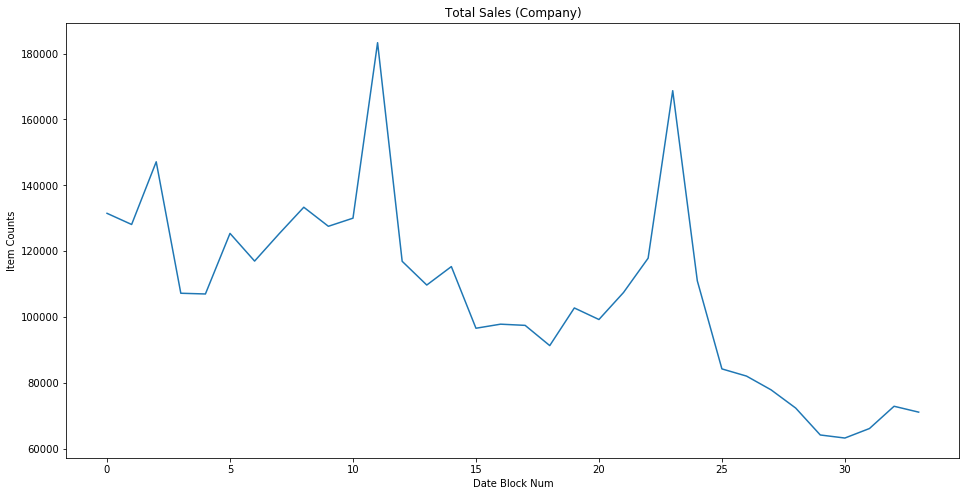

In [15]:
grouped_df = train_df.groupby(['date_block_num']).agg({'item_cnt_day': 'sum' })

plt.figure(figsize=(16,8))
plt.plot(grouped_df)

plt.title('Total Sales (Company)')
plt.xlabel('Date Block Num')
plt.ylabel('Item Counts')

There does appear to be a seasonality to the data.

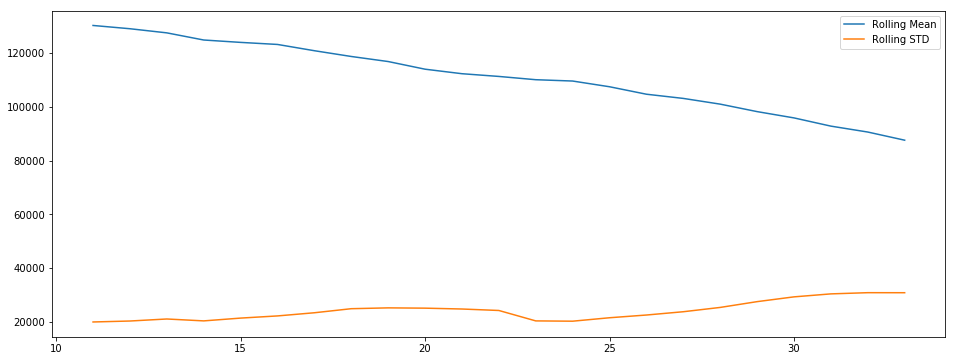

In [16]:
plt.figure(figsize=(16,6))

plt.plot(grouped_df.rolling(window=12, center=False).mean(), label='Rolling Mean');
plt.plot(grouped_df.rolling(window=12, center=False).std(), label='Rolling STD');

plt.legend();

It looks like there is a decreasing sales trend.

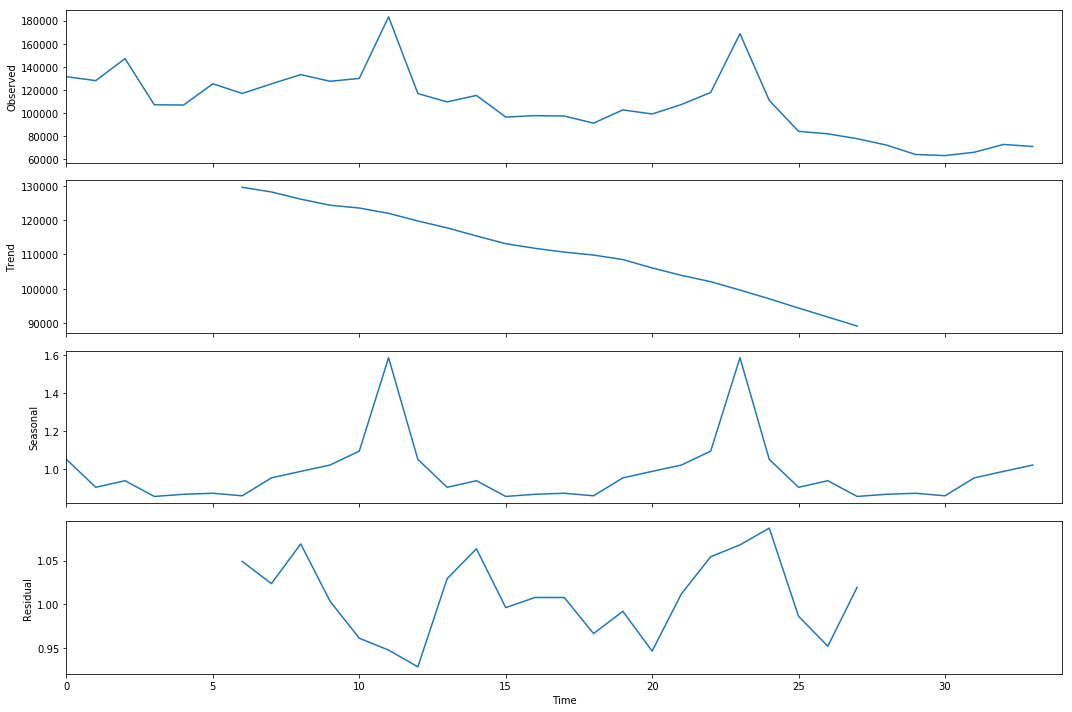

In [17]:
import statsmodels.api as sm

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10

# multiplicative
res = sm.tsa.seasonal_decompose(grouped_df.values, freq=12, model='multiplicative')

fig = res.plot()

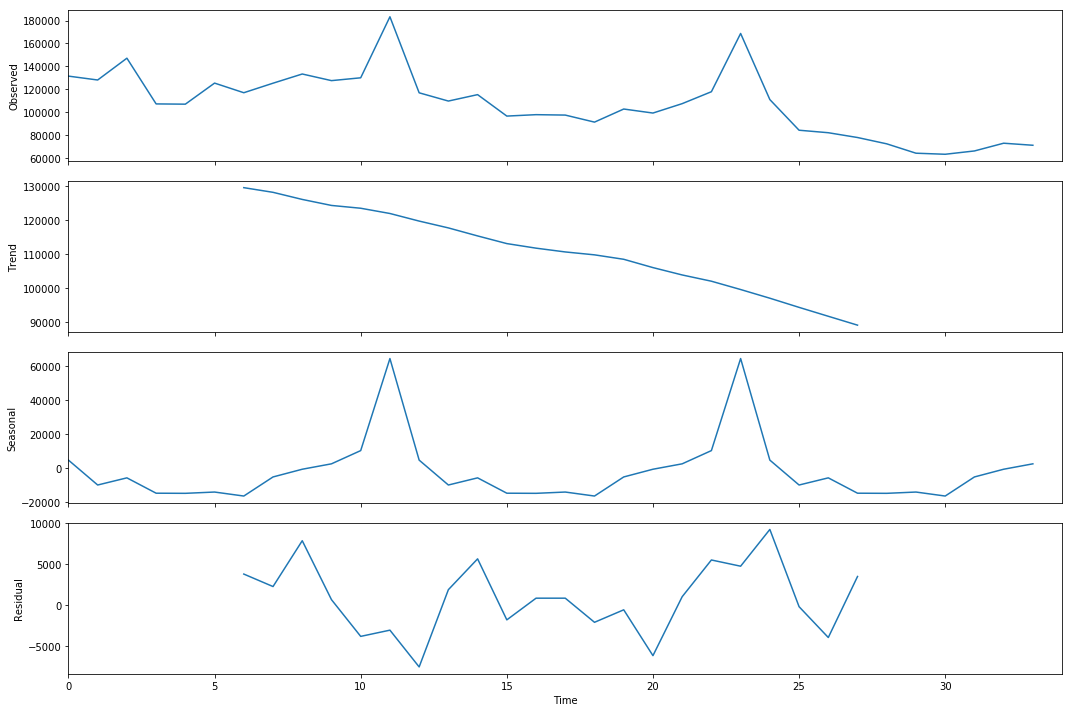

In [18]:
# additive
res = sm.tsa.seasonal_decompose(grouped_df.values, freq=12, model='additive')

fig = res.plot()

Add some lagged features.

In [19]:
# TODO:  You will eventually need all of the training features.
train_df = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum'}).reset_index()
train_df.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']

for m in [1, 2, 3, 6, 12]:
    new_col = 'item_cnt_month (-{:})'.format(m)
    
    shifted = train_df[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']].copy()
    shifted.columns = ['date_block_num', 'shop_id', 'item_id', new_col]
    shifted['date_block_num'] += m
    
    train_df = pd.merge(train_df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    train_df[new_col] = train_df[new_col].fillna(0.0)
    
train_df.tail(5)

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month (-1),item_cnt_month (-2),item_cnt_month (-3),item_cnt_month (-6),item_cnt_month (-12)
1609119,33,59,22087,6.0,3.0,2.0,5.0,2.0,6.0
1609120,33,59,22088,2.0,1.0,7.0,7.0,3.0,7.0
1609121,33,59,22091,1.0,3.0,0.0,0.0,0.0,1.0
1609122,33,59,22100,1.0,1.0,0.0,0.0,0.0,0.0
1609123,33,59,22102,1.0,0.0,2.0,0.0,0.0,0.0


The following code is how coursera recommends that the data be aggregated.

In [20]:
from itertools import product

sales = train_df

index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num'] == block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num'] == block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols, as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#fix column names
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left', on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'], inplace=True)

all_data.head(5)

SpecificationError: cannot perform renaming for item_cnt_day with a nested dictionary